In [116]:
library(tidyverse)
library(magrittr)
library(janitor)
library(patchwork)
library(ggridges)
source("../scripts/helper_functions.R")

In [117]:
meteor <- read_csv("../data/meteor.csv", show_col_types = FALSE) %>% select(clade_name, matches("1_6"))
x <- read_csv("../data/meteor.csv", show_col_types = FALSE) %>% select(clade_name, superkingdom:species)
meteor %>%  select(clade_name, matches("G")) %>% column_to_rownames("clade_name") -> df1
meteor %>% select(clade_name, matches("ASAL")) %>% column_to_rownames("clade_name") -> df2

In [118]:
## K-S test
results_ks <- tibble(clade_name = rownames(df1),
				  test = numeric(nrow(df1)), 
				  pvalue = numeric(nrow(df1)))
for (i in 1:nrow(df1)) { group1 <- as.numeric(df1[i, ]) 
				    group2 <- as.numeric(df2[i, ])  
# Perform Kolmogorov-Smirnov test 
ks_test <- ks.test(group1, group2) # Store results 
results_ks$test[i] <- ks_test$statistic 
results_ks$pvalue[i] <- ks_test$p.value }
results_ks$significant <- results_ks$pvalue < 0.05
# Adjust p-values for multiple comparisons
results_ks$adjusted_pvalue <- p.adjust(results_ks$pvalue, method = "BH")
results_ks %<>% mutate(test = "KS") %>% tibble()
results_ks$prev <-  rowSums(cbind(df1,df2) > 0) 
results_ks$max_cov <- MatrixGenerics::rowMaxs(as.matrix(cbind(df1,df2)))

In [119]:
df1 %>%
rowMeans() %>%
enframe("clade_name", "mean_g") %>%
left_join((df1 %>%
  mutate(prevalence_g = rowSums(select(df1, matches("G[0-9]")) > 0 )) %>% 
           rownames_to_column("clade_name") %>% select(clade_name,prevalence_g))) %>% 
full_join(
df2 %>%
rowMeans() %>%
enframe("clade_name", "mean_a") %>%
left_join((df2 %>%
  mutate(prevalence_a = rowSums(select(df2, matches("ASAL")) > 0 )) %>% 
           rownames_to_column("clade_name") %>% select(clade_name,prevalence_a)))) %>% 
mutate_if(is.numeric, ~ ifelse(is.na(.), 0, .)) %>%
full_join(results_ks) %>% 
select(clade_name:prevalence_a,prev,max_cov,  "KS_p" =adjusted_pvalue) %>% 
left_join(x) %>% 
arrange(phylum, class, order, family, genus, species) %>% 
mutate(problem = case_when(order %in% problematic_orders ~ 1, TRUE ~ 0.5), .after = max_cov) %>% 
mutate(phylum2 = phylum) %>%
mutate(phylum = case_when(max_cov >= 0.2 & prevalence_g > 10 & prevalence_a > 5 ~ phylum, TRUE ~ "low")) %>%
arrange(phylum) %>%
mutate(clade_name = factor(clade_name, levels = clade_name)) %>%
mutate(signif = case_when(-log(KS_p) > 3  ~ TRUE, TRUE ~ FALSE),.after = clade_name) -> p
####
p$phylum <- factor(p$phylum, levels = unique(p$phylum))
phylum_levels <- unique(p$phylum)
color <- c(
  "#87CEFA",  # Actinomycetota
  "#EE6A50",  # Bacillota
  "#EE6A50",  # Bacillota_A
  "#EE6A50",  # Bacillota_C
  "#FFC125",  # Bacteroidota
  "#006400",  # Campylobacterota
  "#FFC0CB",  # Fusobacteriota
  "#303030",  # Patescibacteria
  "#9ACD32",  # Pseudomonadota
   "#8B4513",  # Spirochaetota
  #"#ff004f",  # Synergistota
  "grey"      # low
)
names(color) <- phylum_levels
#### start the ggplot 

Joining with `by = join_by(clade_name)`
Joining with `by = join_by(clade_name)`
Joining with `by = join_by(clade_name)`
Joining with `by = join_by(clade_name)`
Joining with `by = join_by(clade_name)`


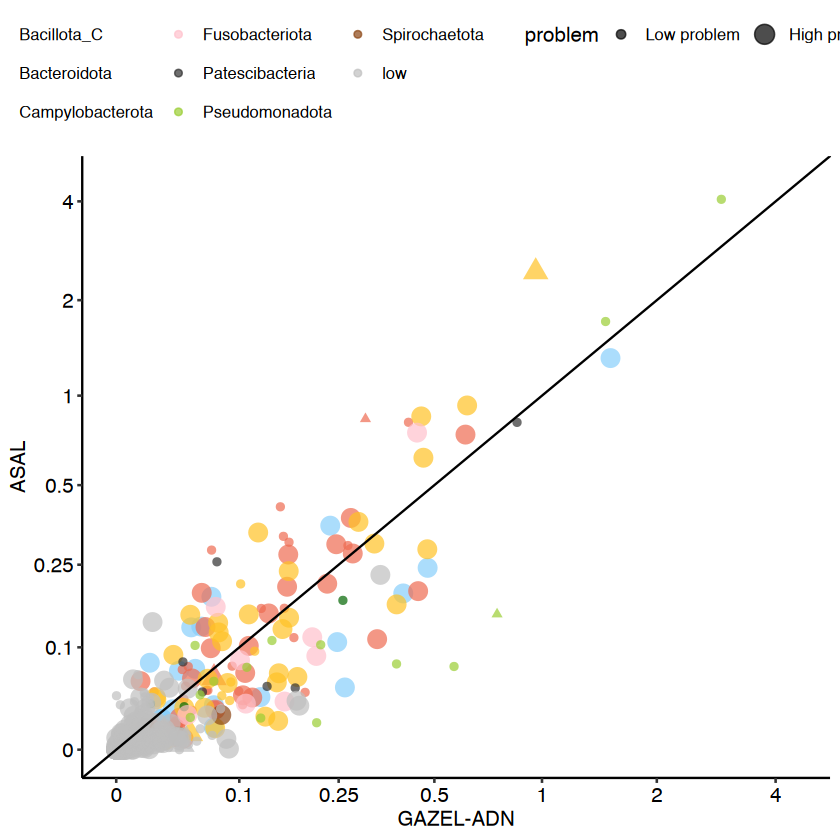

In [120]:
p$phylum <- factor(p$phylum, levels = names(color))
p %>%  ggplot(aes(mean_g, mean_a, color = phylum, shape =signif)) +
  geom_point(aes(size = problem), alpha = 0.7) +
  scale_color_manual(values = color) +
  scale_size_continuous(
    range = c(2, 5),  # Adjust bubble size range (min, max)
    breaks = c(0.5, 1),  # Optional: Specify specific size levels
    labels = c("Low problem", "High problem")  # Optional: Add labels for the legend
  ) +
  geom_abline(intercept=0, slope=1) +
  ggpubr::theme_pubr() +
  scale_y_continuous(
    trans = zoom_trans,
    limits = c(0, 4.5),
	    breaks = c(0, 0.1, 0.25, 0.5, 1, 2, 4),
    labels = c( "0", "0.1", "0.25", "0.5", "1", "2", "4")
  ) +
  ylab("ASAL") +
    scale_x_continuous(
    trans = zoom_trans,
    limits = c(0, 4.5),
	    breaks = c(0, 0.1, 0.25, 0.5, 1, 2, 4),
    labels = c( "0", "0.1", "0.25", "0.5", "1", "2", "4")
  ) +
  xlab("GAZEL-ADN") -> rarefied ; rarefied

In [121]:
p %>% filter(signif == TRUE) %>%
             select(clade_name:KS_p, phylum, phylum2,species) %$% clade_name ->  ridge
ridge

[1] msp_2269  msp_1219  msp_1782  msp_2438  msp_2225  msp_0677c msp_2391 
[8] msp_2362  msp_2276 
647 Levels: msp_2249 msp_0437c msp_2265 msp_2448 msp_2912 msp_2227 ... msp_0409

In [122]:
df1_long <- df1 %>%
as.data.frame() %>%
rownames_to_column("msp_name") %>%
pivot_longer(-msp_name, names_to = "sample", values_to = "value") %>%
mutate(group = "miG")
df2_long <- df2 %>%
as.data.frame() %>%
rownames_to_column("msp_name") %>%
pivot_longer(-msp_name, names_to = "sample", values_to = "value") %>%
mutate(group = "ASAL")
# Step 2: Combine
combined_df <- bind_rows(df1_long, df2_long)
filtered_df <- combined_df %>%
  filter(msp_name %in% ridge)

In [123]:
ecdf_df  <- filtered_df %>% 
group_by(msp_name, group) %>% 
arrange(value) %>% 
mutate(ecdf = ecdf(value)(value)) 

In [124]:
ecdf_df %<>% left_join(x, by = c("msp_name" = "clade_name")) %>% ungroup() %>% 
mutate(phylum = factor(phylum, levels=sort(unique(phylum)))) 

 ecdf_df %>% unite("taxonomy", phylum:species) %$% taxonomy %>% unique() %>% sort() %>% rev() -> lev
 ecdf_df %<>% unite("taxonomy", phylum:species) %>%
             mutate(taxonomy = factor(taxonomy, levels = lev))


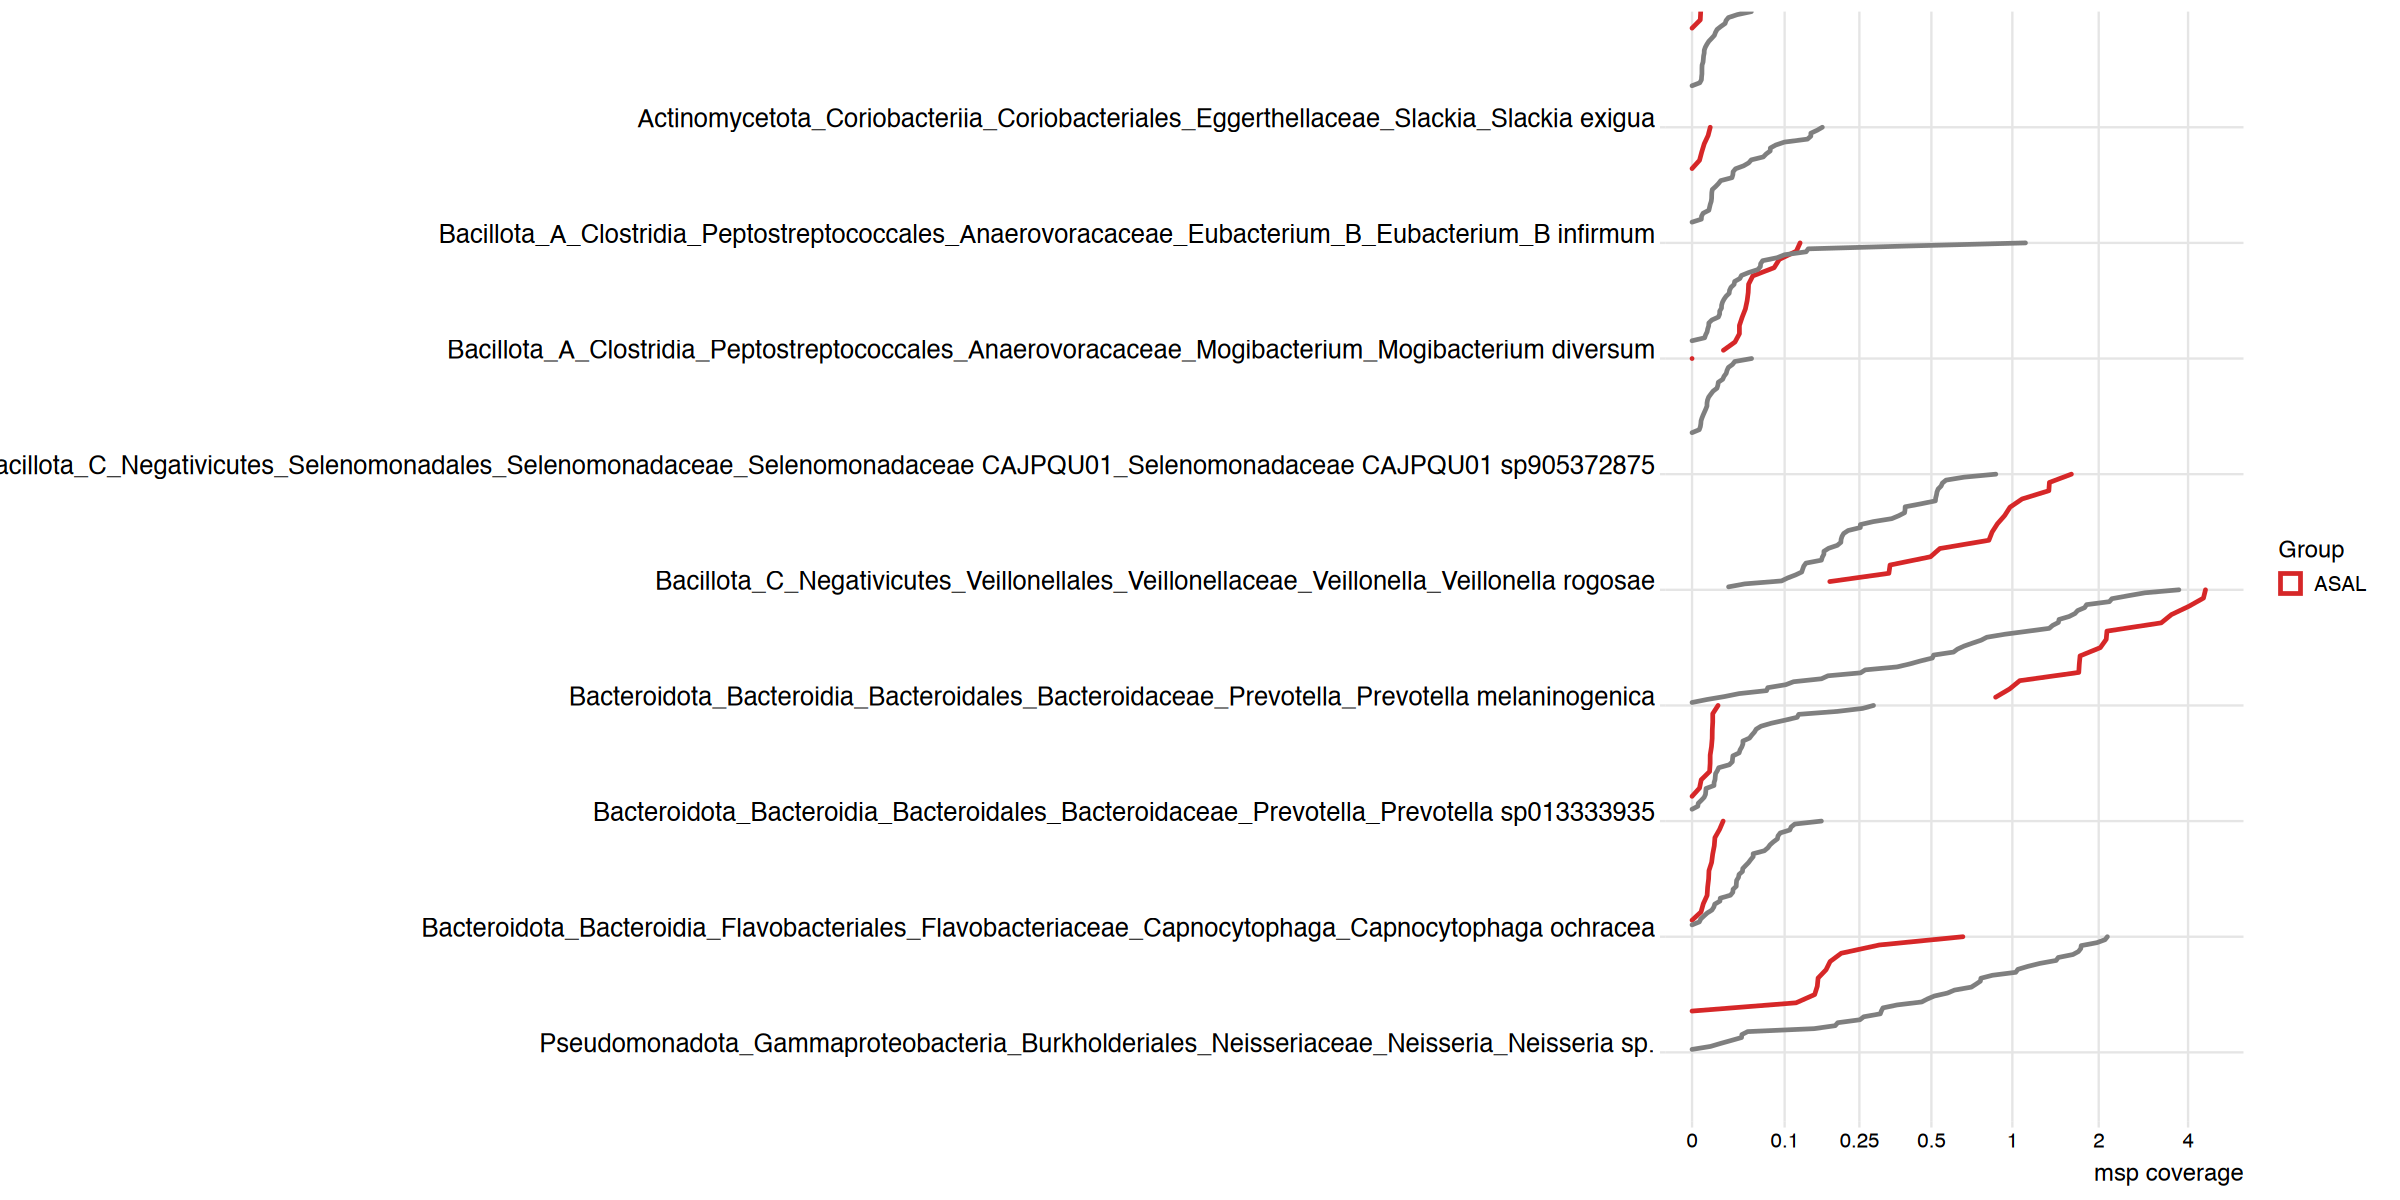

In [131]:
options(repr.plot.width=20, repr.plot.height=10)
# Step 5: Ridgeline plot
ggplot(ecdf_df, aes(x = value, y = taxonomy, height = ecdf, color = group)) +
                            geom_ridgeline(fill = NA, scale = 1, linewidth=1) +
                            scale_color_manual(values = c("GAZEL_ADN" = "#1f77b4", "ASAL" = "#d62728")) +
                            theme_minimal(base_size = 12) +
                            labs(x = "msp coverage", y = NULL, color = "Group") +
               ggridges::theme_ridges() +
             scale_x_continuous(
               trans = zoom_trans,
               limits = c(0, 5),
               breaks = c(0, 0.1, 0.25, 0.5, 1, 2, 4),
                 labels = c("0", "0.1", "0.25", "0.5", "1", "2", "4")
             ) +
               theme(
                 axis.text.y = element_text(size = 15),
                 legend.position = "right"
               ) -> k_s_ridge; k_s_ridge
  